In [1]:
import numpy as np
import itertools
import warnings
import pickle

from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              BaggingClassifier)
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)

from viz import (plot_predicted_scores, plot_precision_recall, plot_auc_roc,
                 plot_feature_importances)

warnings.filterwarnings("ignore")


INPUT_DIR = "../processed_data/"
OUTPUT_DIR = "../log/"
OUTPUT_FILE = "performances.csv"

MODEL_NAMES = ["KNN", "Logistic Regression", "Decision Tree", "Linear SVM",
               "Bagging", "Boosting", "Random Forest"]
MODELS = [KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier,
          LinearSVC, BaggingClassifier, AdaBoostClassifier, RandomForestClassifier]

METRICS_NAMES = ["Accuracy", "Precision", "Recall", "F1 Score", "AUC ROC Score"]
METRICS = [accuracy_score, precision_score, recall_score, f1_score, roc_auc_score]

THRESHOLDS = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
SEED = 123

GRID_SEARCH_PARAMS = {"KNN": {
                              'n_neighbors': list(range(50, 110, 20)),
                              'weights': ["uniform", "distance"],
                              'metric': ["euclidean", "manhattan", "minkowski"]
                              },

                      "Logistic Regression": {
                                              'penalty': ['l1', 'l2'],
                                              'C': [0.001, 0.01, 0.1, 1, 10],
                                              'solver': ['newton-cg', 'lbfgs', 'liblinear']
                                              },

                      "Decision Tree": {
                            'criterion': ["entropy", "gini"],
                            'min_samples_split': list(np.arange(0.02, 0.05, 0.01)),
                            'max_depth': list(range(4, 11)),
                            'max_features': list(range(4, 15, 2))
                            },

                      "Linear SVM": {
                                     'penalty': ['l1', 'l2'],
                                     'C': [0.001, 0.01, 0.1, 1, 10]
                                     },

                      "Bagging": {
                                  'max_samples': [0.05, 0.1, 0.2, 0.5],
                                  'max_features': list(range(4, 15, 2))
                                  },

                      "Boosting":{
                                  'algorithm': {"SAMME", "SAMME.R"},
                                  'learning_rate': [0.001, 0.01, 0.1, 0.5, 1, 10]
                                  },

                      "Random Forest": {
                            'min_samples_split': list(np.arange(0.01, 0.06, 0.01)),
                            'max_depth': list(range(4, 11)),
                            'max_features': list(range(4, 15, 2))
                            }
                      }

DEFAULT_ARGS = {"KNN": {'n_jobs': -1},
                "Logistic Regression": {'random_state': SEED},
                "Decision Tree": {'random_state': SEED},
                "Linear SVM": {'random_state': SEED, 'max_iter': 200},
                "Bagging": {'n_estimators': 50, 'random_state': SEED,
                            'oob_score': True, 'n_jobs': -1},
                "Boosting": {'n_estimators': 100, 'random_state': SEED},
                "Random Forest": {'n_estimators': 300, 'random_state': SEED,
                                  'oob_score': True, 'n_jobs': -1}}

In [2]:
def load_features(dir_path=INPUT_DIR, test=True):
    """
    Load pre-processed feature matrices.

    """
    Xs = np.load(dir_path + 'X.npz')
    ys = np.load(dir_path + 'y.npz')

    if not test:
        X_train = Xs['train']
        y_train = ys['train']
        return X_train, y_train

    X_train, X_test = Xs['train'], Xs['test']
    y_train, y_test = ys['train'], ys['test']
    return X_train, X_test, y_train, y_test


def build_benchmark(data, metric_index):
    """
    """
    X_train, X_test, y_train, y_test = data

    benchmark = DecisionTreeClassifier(**DEFAULT_ARGS["Decision Tree"])
    benchmark.fit(X_train, y_train)
    predicted_probs = benchmark.predict_proba(X_test)[:, 1]
    benchmark_score = METRICS[metric_index](y_test, benchmark.predict(X_test))

    print("\n{} of the benchmark default decision tree model is {:.4f}.\n".\
          format(METRICS_NAMES[metric_index], round(benchmark_score, 4)))

    return benchmark_score

In [3]:
X_train, X_test, y_train, y_test = load_features()

In [4]:
benchmark = DecisionTreeClassifier(**DEFAULT_ARGS["Decision Tree"])

In [5]:
benchmark.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [6]:
hasattr(benchmark, "feature_importances_")

True

In [7]:
            with open(INPUT_DIR + 'col_names.pickle', 'rb') as handle:
                col_names = pickle.load(handle)
                print(col_names)

Index(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberRealEstateLoansOrLines', 'NumberOfDependents', 'PastDue',
       'zipcode_60601', 'zipcode_60618', 'zipcode_60625', 'zipcode_60629',
       'zipcode_60637', 'zipcode_60644'],
      dtype='object')


In [23]:
clf = benchmark
n = 5

In [24]:
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1][:n]
    labels = col_names[indices]

In [39]:
sorted(importances)[:n]

[0.01114763023318237,
 0.012787777342147828,
 0.013523677919574522,
 0.014451305373616764,
 0.01555631643232033]

In [26]:
labels

Index(['PastDue', 'RevolvingUtilizationOfUnsecuredLines', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans'],
      dtype='object')

In [27]:
"""
Summary:     A collections of functions for visualization.

Description: contains a function that reads data and data types, and many
             other functions for visualization
Author:      Kunyu He, CAPP'20
"""

import os
import json
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.font_manager import FontProperties
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve


INPUT_DIR = "../data/"
OUTPUT_DIR = "../log/images/"

COLORS = list(sns.color_palette("Set2")) + list(sns.color_palette("Set3"))
TITLE = FontProperties(family='serif', size=14, weight="semibold")
AXIS = FontProperties(family='serif', size=12)
TICKS = FontProperties(family='serif', size=10)

POSITIVE = 1
N_CLASSES = 2


([<matplotlib.axis.XTick at 0x15ed5922d30>,
 <a list of 5 Text xticklabel objects>)

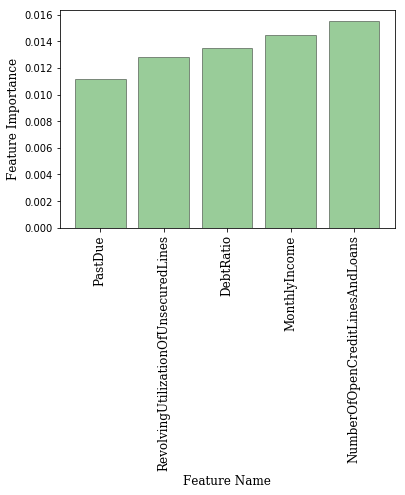

In [37]:
    fig, ax = plt.subplots()
    plt.bar(range(n), sorted(clf.feature_importances_)[:n], color='g',
            alpha=0.4, edgecolor=['black']*n)
    plt.ylabel("Feature Importance", fontproperties=AXIS)
    plt.xlabel("Feature Name", fontproperties=AXIS)
    plt.xticks(np.arange(n), labels, rotation='vertical', fontproperties=AXIS)

([<matplotlib.axis.YTick at 0x15ed5d805c0>,
 <a list of 5 Text yticklabel objects>)

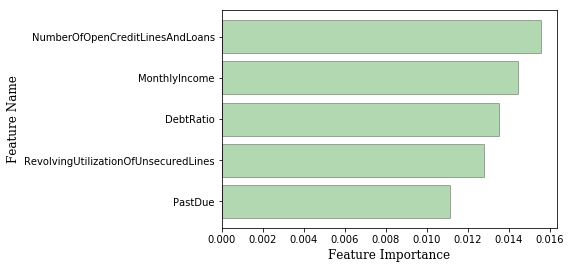

In [33]:
fig, ax = plt.subplots()
plt.barh(range(n), sorted(clf.feature_importances_)[:n], color='g',
         alpha=0.3, edgecolor='black')
plt.xlabel("Feature Importance", fontproperties=AXIS)
plt.ylabel("Feature Name", fontproperties=AXIS)
plt.yticks(np.arange(n), labels)


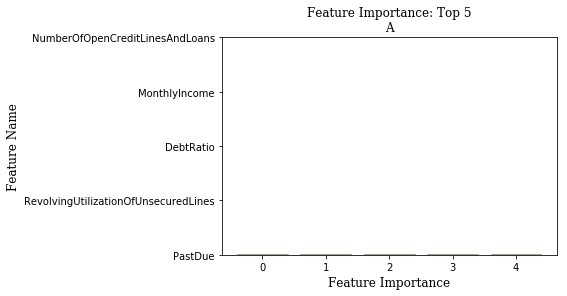

In [21]:
fig, ax = plt.subplots()
plt.bar(range(n), sorted(clf.feature_importances_)[:n], color='g',
         alpha=0.3, edgecolor='black')
plt.xlabel("Feature Importance", fontproperties=AXIS)
plt.ylabel("Feature Name", fontproperties=AXIS)
plt.yticks(np.arange(n), labels)
figname = OUTPUT_DIR + "feature importance/" + "{}.png".format("A")
plt.title("Feature Importance: Top {}\n".format(n) + "A",
              fontproperties=AXIS)
fig.savefig(figname, dpi=400)

In [ ]:
def plot_feature_importances(clf, col_names, n=5, title=""):
    """
    Plot the feature importances of the decision tree. This credit to the
    University of Michigan.

    Inputs:
        clf: the model
        feature_names: (list) the list of strings to store feature names

    Returns:
        None
    """
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1][:n]
    labels = col_names[indices]

    fig, ax = plt.subplots()
    plt.barh(range(n), sorted(clf.feature_importances_)[:n], color='g',
             alpha=0.3, edgecolor='black')

    plt.xlabel("Feature Importance", fontproperties=AXIS)
    plt.ylabel("Feature Name", fontproperties=AXIS)
    plt.yticks(np.arange(n), labels)

    figname = OUTPUT_DIR + "feature importance/" + "{}.png".format(title)
    plt.title("Feature Importance: Top {}\n".format(n) + title,
              fontproperties=AXIS)
    fig.savefig(figname, dpi=400)

    fig.tight_layout()
    plt.show(block=False)
    plt.pause(3)
    plt.close()
